In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile
from glob import glob

import sys
import importlib
import json

In [71]:
# Settings --------------------------------------
dataset_path = "../data/datasets/impulse_response_medium_evaluation.hdf5"

model_folder = "../runs/gallant-waterfall-89/"
checkpoint = "gallant-waterfall-89_400.pth"#new_type_dataset_medium_astral-shadow-62_900.pth" #False

# model_folder = "../runs/non_wandb/"
# checkpoint = "not_logged_0.pth" #False

# model_folder = "../runs/gcc_phat/"
# checkpoint = False

batch_size = 100 # just needed to make computation smooth
device = "cpu"#'cuda:1' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
reference_sound_folder = '../data/reference_data/reference_sounds/'
#-------------------------------------------------


# Load model

In [72]:
class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.thinker = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["factor"]*config["cnn_output_size_at_factor_1"],1000),
            nn.GELU(),
            #Block(1000),
            #Block(1000),
            nn.Linear(1000,config["guess_grid_size"])
        )
        
        self.apply(self._init_weights)
        
        self.cnn = nn.Sequential(
            nn.Conv1d(4,48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 30,stride=5),
            nn.GELU(),
            nn.Flatten(),
        )
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
        
                
    def forward(self, x):
        x = self.cnn(x)
        x = self.thinker(x)
        return x

config = json.load(open(os.path.join(model_folder,"config.json"),'r'))

sys.path.append(model_folder)
model_file = importlib.import_module((config["model"]))

model = model_file.model(config)
if checkpoint:
    model = torch.load(os.path.join(model_folder,"checkpoints",checkpoint), map_location=device)
    model.eval() # regression on dropout is not great

In [4]:
with h5py.File(dataset_path, 'r') as hdf5_file:

    X = hdf5_file["input"]
    y = hdf5_file["gt"]

    class custom_dataset(Dataset):

        def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
            self.X = X
            self.y = y
            self.dataset_len = dataset_len
            self.idx_min = idx_min

        def __getitem__(self, idx):

            mics_idx = torch.randperm(X.shape[1])[:config["mics_per_batch"]].sort()[0] # sorting because hdf5 requires it
            return self.X[idx + self.idx_min, mics_idx],self.y[idx + self.idx_min, mics_idx]

        def __len__(self):
            return self.dataset_len

    # package datasets
    
    dataset = custom_dataset(X,y)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    def y_to_class_gt(y, guess_grid_size, max_shift) :
        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

        bin_width = max_shift*2/guess_grid_size
        y = (y/bin_width).round() + guess_grid_size // 2 
        y[y == guess_grid_size] = guess_grid_size - 1
        return y.long()


    def format_simulated_data(X,y):
        """
        transform a tensor of impulse responses in different rooms into pairwise TimeEstimation-problems. Note (X and y should be on GPU)

        """
        #pull a random sound
        sound_paths = glob(os.path.join(reference_sound_folder, "*.wav"))
        sound_path = sound_paths[np.random.randint(len(sound_paths))]
        fs,signal = wavfile.read(sound_path)
        start = np.random.randint(0,len(signal) - config["sample_length"] - config["rir_len"]-1, X.shape[0])
        # simulate longer sound and then cut to the relevant piece
        signals = np.zeros((X.shape[0], config["sample_length"] + config["rir_len"]-1))
        for i in range(X.shape[0]):
            signals[i,:] = signal[start[i]:start[i]  + config["sample_length"] + config["rir_len"]-1]
        #signals = torch.tensor(signals).to(torch.float32).to(device).unsqueeze(1)
        signals = torch.tensor(signals).to(torch.float32).unsqueeze(1)

        q = torch.fft.irfft(torch.fft.rfft(signals)*torch.fft.rfft(X,signals.shape[2]))[:,:,:config["sample_length"]] # compute the heard sound, and cut it to the right length
        q = torch.fft.rfft(q)[:,:,:config["max_freq"]] # cut frequencies which are too high
        q = q.unsqueeze(2)
        q = torch.concatenate([torch.concatenate([q,q.roll(i+1, 1)], dim=2) for i in range(config["mics_per_batch"] // 2)],dim=1) # organize sounds pairwise
        q = q.view(X.shape[0]*(config["mics_per_batch"]*(config["mics_per_batch"] - 1 ))//2, 2,-1) # reshape so that each example is a row
        X = torch.concatenate([q.real,q.imag],dim=1)
        y = torch.concatenate([y - y.roll(i+1,1) for i in range(config["mics_per_batch"]//2)],dim=1).view(-1)*fs/343 # compute gt for all pairs
        y = y_to_class_gt(y, config["guess_grid_size"], config["max_shift"]).to(torch.long)
        
        return X,y


  
    preds = []
    ys = []
    with torch.no_grad():
        print_loss = 0
        counter = 0
        for batch, (X,y) in enumerate(dataloader):
            
            # Compute prediction error
            X,y = format_simulated_data(X,y)
            Xsim = X
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            preds.append(pred)
            ys.append(y)

    preds = torch.concatenate(preds, dim=0)
    ys = torch.concatenate(ys, dim=0)
                        
    preds = preds.to("cpu")
    ys = ys.to("cpu")



    
res = preds.argmax(dim=1) - ys

print(f'Inlier ratio (< ~15 cm) : {((res.abs() < 2).sum()/res.numel()).item():.2f}')


Inlier ratio (< ~15 cm) : 0.88


In [5]:
with h5py.File("../data/datasets/paired_fft_music_0014_evaluation.hdf5", 'r') as hdf5_file:

    X = hdf5_file["input"]
    y = hdf5_file["gt"]

    class paired_fft_dataset(Dataset):

        def __init__(self, X, y, idx_min=0,dataset_len=len(X)):
            self.X = X
            self.y = y
            self.dataset_len = dataset_len
            self.idx_min = idx_min

        def __getitem__(self, idx):

            #mics_idx = torch.randperm(X.shape[1])[:config["mics_per_batch"]].sort()[0] # sorting because hdf5 requires it
            return self.X[idx + self.idx_min],self.y[idx + self.idx_min]

        def __len__(self):
            return self.dataset_len

    # package datasets
    
    dataset = paired_fft_dataset(X,y)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    def y_to_class_gt(y, guess_grid_size, max_shift) :
        y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

        bin_width = max_shift*2/guess_grid_size
        y = (y/bin_width).round() + guess_grid_size // 2 
        y[y == guess_grid_size] = guess_grid_size - 1
        return y.long()

 
    preds = []
    ys = []
    with torch.no_grad():
        print_loss = 0
        counter = 0
        for batch, (X,y) in enumerate(dataloader):
            
            # Compute prediction error
            #X,y = format_simulated_data(X,y)
            Xreal = X
            y = y_to_class_gt(y*16000/343, config["guess_grid_size"], config["max_shift"]).to(torch.long)
            X = X.to(device)
            y = y.to(device)
            X = X/4e4
            X[:,:,:50] = 0
            #X = X*torch.tensor(rescale)/torch.tensor(rescale_target)
            pred = model(X)
            preds.append(pred)
            ys.append(y)

    preds = torch.concatenate(preds, dim=0)
    ys = torch.concatenate(ys, dim=0)
                        
    preds = preds.to("cpu")
    ys = ys.to("cpu")



    
res = preds.argmax(dim=1) - ys

print(f'Inlier ratio (< ~15 cm) : {((res.abs() < 2).sum()/res.numel()).item():.2f}')


Inlier ratio (< ~15 cm) : 0.25


(array([1452., 1694.,  847.,  487.,  258.,  139.,   90.,   59.,   33.,
          33.]),
 array([0.05256392, 0.1472975 , 0.24203108, 0.33676466, 0.43149826,
        0.52623183, 0.62096542, 0.71569902, 0.81043255, 0.90516615,
        0.99989974]),
 <BarContainer object of 10 artists>)

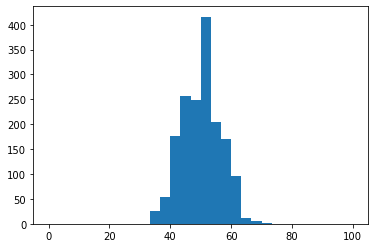

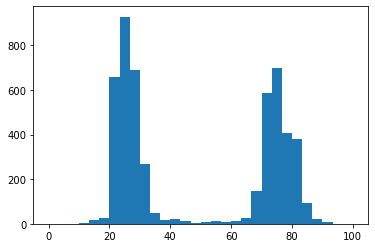

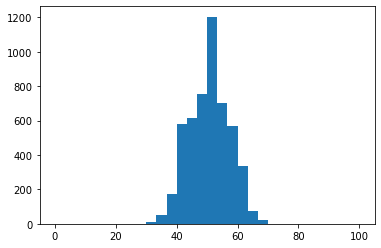

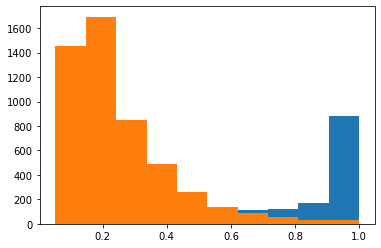

In [6]:
plt.hist(preds.argmax(dim=1)[res.abs() < 2],30,range=(0,100));

plt.figure()
plt.hist(preds.argmax(dim=1)[res.abs() > 2],30,range=(0,100));

plt.figure()
#plt.hist(ys[res.abs() < 2],30,range=(0,100));
#plt.xlim(0,100)
#plt.figure()
plt.hist(ys[res.abs() > 2],30,range=(0,100));

plt.figure();
plt.hist(preds[res.abs() < 2].softmax(dim=1).max(dim=1)[0])
plt.hist(preds[res.abs() > 2].softmax(dim=1).max(dim=1)[0])

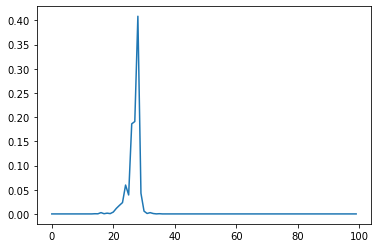

In [7]:
plt.plot(preds[308].softmax(0))

tensor(4.4698e+09)
tensor(96410.0156)


NameError: name 'rescale' is not defined

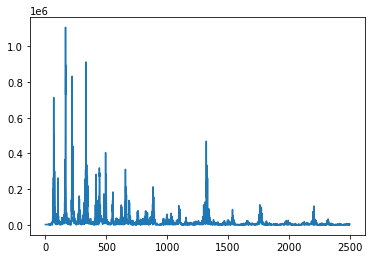

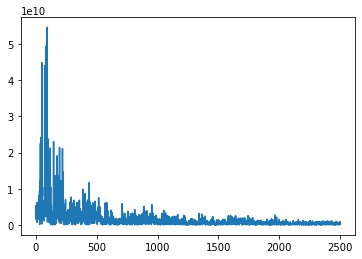

In [8]:
print(Xreal.std(2).mean(1).median())
print(Xsim.std(2).mean(1).median())

i = np.random.randint(300)
plt.plot(Xsim[i,0].abs())
plt.figure()
i = np.random.randint(50)
plt.plot(Xreal[i,0].abs())

(torch.tensor(rescale)*Xreal[i,0]/torch.tensor(rescale_target)).abs()

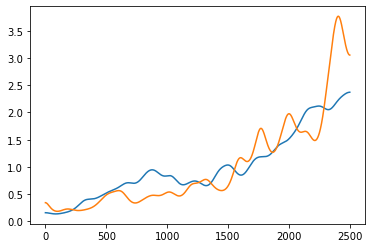

In [ ]:

rescale = 1/sp.ndimage.gaussian_filter1d(Xreal.abs().sum(1).sum(0),50)
rescale /= rescale.mean()

rescale_target = 1/sp.ndimage.gaussian_filter1d(Xsim.abs().sum(1).sum(0),50)
rescale_target /= rescale_target.mean()

plt.plot(rescale)
plt.plot(rescale_target)

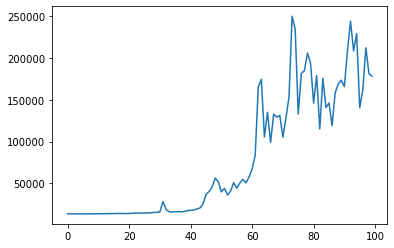

In [ ]:
plt.plot((Xsim.abs()).mean(0)[0][:100])

In [70]:
#Xsim.std(dim=2).mean(dim=1).unsqueeze(1).unsqueeze(2)
#pred

a = torch.arange(config["guess_grid_size"]).unsqueeze(1)

cost_cap = torch.tensor(10)
cost = torch.minimum( (a - a.T).abs(),cost_cap)

#cost = cost[y].to(torch.float)

#(pred, 1)
#pred.softmax(1)*cost[y]
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(pred,y)


-(pred.softmax(1)[np.arange(y.shape[0]),y].log()).mean() # CrossEntropy
(pred.softmax(1) * cost[y]).sum(1)




tensor([[ 0,  1,  2,  ..., 10, 10, 10],
        [ 1,  0,  1,  ..., 10, 10, 10],
        [ 2,  1,  0,  ..., 10, 10, 10],
        ...,
        [10, 10, 10,  ...,  0,  1,  2],
        [10, 10, 10,  ...,  1,  0,  1],
        [10, 10, 10,  ...,  2,  1,  0]])